<a href="https://colab.research.google.com/github/Dileeban1108/PyTorch-Computer-Vision/blob/main/03_pytorch_computer_vision_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 03. PyTorch Computer Vision Exercises

The following is a collection of exercises based on computer vision fundamentals in PyTorch.

They're a bunch of fun.

You're going to get to write plenty of code!

## Resources

1. These exercises are based on [notebook 03 of the Learn PyTorch for Deep Learning course](https://www.learnpytorch.io/03_pytorch_computer_vision/).
2. See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/_PibmqpEyhA).
  * **Note:** Going through these exercises took me just over 3 hours of solid coding, so you should expect around the same.
3. See [other solutions on the course GitHub](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/extras/solutions).

In [ ]:
# Check for GPU
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
# Import torch
import torch

# Exercises require PyTorch > 1.10.0
print(torch.__version__)

# TODO: Setup device agnostic code


2.8.0+cu126


## 5. Load the [`torchvision.datasets.MNIST()`](https://pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html#torchvision.datasets.MNIST) train and test datasets.

In [ ]:
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

train_data=datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)
test_data=datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

100%|██████████| 9.91M/9.91M [00:00<00:00, 53.2MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.69MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.9MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.88MB/s]


In [ ]:
# See classes
class_names = train_data.classes
class_names

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

In [ ]:
image, label=train_data[0]
image.shape, label

(torch.Size([1, 28, 28]), 5)

## 6. Visualize at least 5 different samples of the MNIST training dataset.

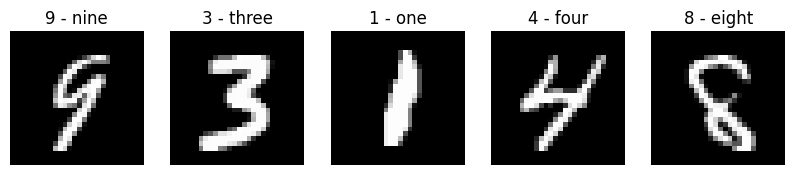

In [ ]:
import matplotlib.pyplot as plt
# torch.manual_seed(42)
fig = plt.figure(figsize=(10, 10))
rows, cols = 1, 5
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(class_names[label])
    plt.axis(False);


## 7. Turn the MNIST train and test datasets into dataloaders using `torch.utils.data.DataLoader`, set the `batch_size=32`.

In [ ]:
from torch.utils.data import DataLoader
batch_size = 16
train_dataloader = DataLoader(train_data, # dataset to turn into iterable
    batch_size=batch_size, # how many samples per batch?
    shuffle=True # shuffle data every epoch?
)

test_dataloader = DataLoader(test_data,
    batch_size=batch_size,
    shuffle=False # don't necessarily have to shuffle the testing data
)

# Let's check out what we've created
print(f"Dataloaders: {train_dataloader, test_dataloader}")
print(f"Length of train dataloader: {len(train_dataloader)} batches of {batch_size}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {batch_size}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x794864d9bc20>, <torch.utils.data.dataloader.DataLoader object at 0x794864d9bc80>)
Length of train dataloader: 3750 batches of 16
Length of test dataloader: 625 batches of 16


In [ ]:
for sample in next(iter(train_dataloader)):
    print(sample.shape)

torch.Size([16, 1, 28, 28])
torch.Size([16])


## 8. Recreate `model_2` used in notebook 03 (the same model from the [CNN Explainer website](https://poloclub.github.io/cnn-explainer/), also known as TinyVGG) capable of fitting on the MNIST dataset.

In [ ]:
# @title
import torch.nn as nn
device = "cuda" if torch.cuda.is_available() else "cpu"
class Mnist_Model(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
                nn.Conv2d(in_channels=input_shape,
                            out_channels=hidden_units,
                            kernel_size=3, # how big is the square that's going over the image?
                            stride=1, # default
                            padding=1),# options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number
                nn.ReLU(),
                nn.Conv2d(in_channels=hidden_units,
                            out_channels=hidden_units,
                            kernel_size=3,
                            stride=1,
                            padding=1),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2,
                            stride=2) # default stride value is same as kernel_size
            )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from?
            # It's because each layer of our network compresses and changes the shape of our input data.
            nn.Linear(in_features=hidden_units*7*7,
                    out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        # print(x.shape)
        x = self.block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x

torch.manual_seed(42)
model_2 = Mnist_Model(input_shape=1,
    hidden_units=10,
    output_shape=len(class_names))
model_2
# model_2.state_dict()

Mnist_Model(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [ ]:
class_names

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

## 9. Train the model you built in exercise 8. for 5 epochs on CPU and GPU and see how long it takes on each.

In [ ]:
from tqdm.auto import tqdm

model_cpu = Mnist_Model(
    input_shape=1,
    hidden_units=10,
    output_shape=len(class_names)
).to("cpu")

loss_fn = nn.CrossEntropyLoss() # this is also called "criterion"/"cost function" in some places
optimizer = torch.optim.SGD(params=model_cpu.parameters(), lr=0.1)

# Train and test model
epochs = 5

for epoch in tqdm(range(epochs)):
    train_loss = 0
    for batch, (X, y) in enumerate (train_dataloader):
            model_cpu.train()
            #put data on cpu
            X, y = X.to("cpu"), y.to("cpu")

            #do the forward pass
            y_pred = model_cpu(X)

            #calculate the loss
            loss = loss_fn(y_pred, y)
            train_loss += loss

            #optimizer zero grad
            optimizer.zero_grad()

            #loss backward
            loss.backward()

            #optimizer step
            optimizer.step()

    train_loss /=len(train_dataloader)

    test_loss_total = 0

    model_cpu.eval()

    with torch.inference_mode():
        for batch, (X_test, y_test) in enumerate (test_dataloader):

            #make sure data in cpu
            X_test, y_test = X_test.to("cpu"), y_test.to("cpu")
            test_pred = model_cpu(X_test)
            test_loss = loss_fn(test_pred, y_test)
            test_loss_total += test_loss

        test_loss_total /= len(test_dataloader)
    print(f"Epoch: {epoch} | Loss: {train_loss:.3f} | Test_loss: {test_loss_total:.3f}")







  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | Loss: 0.223 | Test_loss: 0.070
Epoch: 1 | Loss: 0.071 | Test_loss: 0.069
Epoch: 2 | Loss: 0.059 | Test_loss: 0.052
Epoch: 3 | Loss: 0.052 | Test_loss: 0.066
Epoch: 4 | Loss: 0.046 | Test_loss: 0.051


In [ ]:
device

In [ ]:
#Train on the GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
model_gpu = Mnist_Model(
    input_shape=1,
    hidden_units=10,
    output_shape=len(class_names)
).to(device)

loss_fn = nn.CrossEntropyLoss() # this is also called "criterion"/"cost function" in some places
optimizer = torch.optim.SGD(params=model_gpu.parameters(), lr=0.1)

# Train and test model
epochs = 5

for epoch in tqdm(range(epochs)):

    model_gpu.train()
    train_loss = 0
    for batch, (X, y) in enumerate (train_dataloader):
            #put data on cpu
            X, y = X.to(device), y.to(device)

            #do the forward pass
            y_pred = model_gpu(X)

            #calculate the loss
            loss = loss_fn(y_pred, y)
            train_loss += loss

            #optimizer zero grad
            optimizer.zero_grad()

            #loss backward
            loss.backward()

            #optimizer step
            optimizer.step()

    train_loss /=len(train_dataloader)

    test_loss_total = 0

    model_gpu.eval()

    with torch.inference_mode():
        for batch, (X_test, y_test) in enumerate (test_dataloader):

            #make sure data in cpu
            X_test, y_test = X_test.to(device), y_test.to(device)
            test_pred = model_gpu(X_test)
            test_loss = loss_fn(test_pred, y_test)
            test_loss_total += test_loss

        test_loss_total /= len(test_dataloader)
    print(f"Epoch: {epoch} | Loss: {train_loss:.3f} | Test_loss: {test_loss_total:.3f}")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | Loss: 0.215 | Test_loss: 0.066
Epoch: 1 | Loss: 0.074 | Test_loss: 0.062
Epoch: 2 | Loss: 0.058 | Test_loss: 0.065
Epoch: 3 | Loss: 0.051 | Test_loss: 0.052
Epoch: 4 | Loss: 0.047 | Test_loss: 0.048


## 10. Make predictions using your trained model and visualize at least 5 of them comparing the prediciton to the target label.

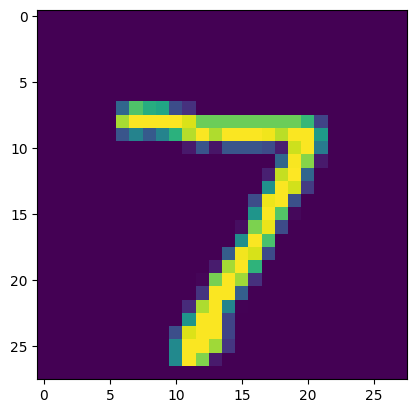

In [ ]:
plt.imshow(test_data[0][0].squeeze())

In [ ]:
model_pred_logits = model_gpu(test_data[0][0].unsqueeze(dim=0).to(device))
model_pred_probs = torch.softmax(model_pred_logits, dim=1)
model_pred_label = torch.argmax(model_pred_probs, dim=1)
model_pred_label

tensor([7])

## 11. Plot a confusion matrix comparing your model's predictions to the truth labels.

In [ ]:
y_preds = []

model_gpu.eval()
with torch.inference_mode():
    for X, y in tqdm(test_dataloader):
        X, y = X.to(device), y.to(device)
        y_pred_logits = model_gpu(X)
        y_pred_probs = torch.softmax(y_pred_logits, dim=1)
        y_pred_labels = torch.argmax(y_pred_probs, dim=1)
        y_preds.append(y_pred_labels)

# Combine all batch predictions
y_preds = torch.cat(y_preds)

print(len(y_preds), len(test_data.targets))


  0%|          | 0/625 [00:00<?, ?it/s]

10000 10000


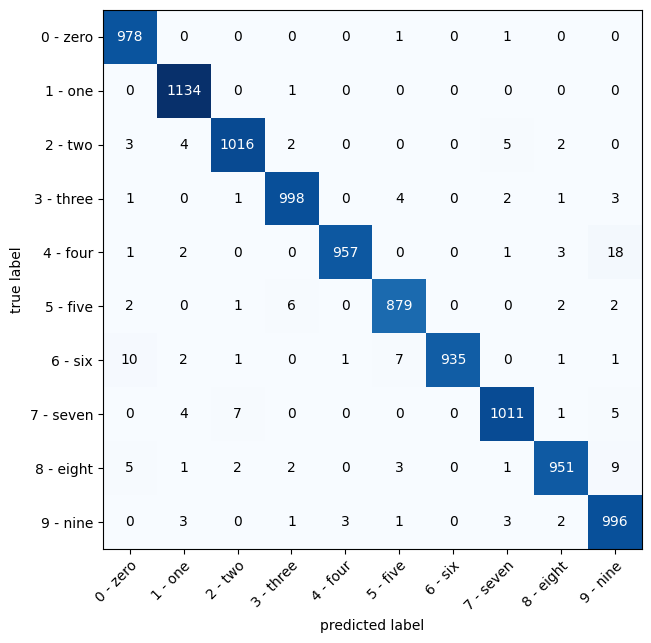

In [ ]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

confmat = ConfusionMatrix(task="multiclass", num_classes=len(class_names))
confmat_tensor = confmat(preds=y_preds.to(device),
                         target=test_data.targets.to(device))

fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.cpu().numpy(),
    class_names=class_names,
    figsize=(10, 7)
)


## 12. Create a random tensor of shape `[1, 3, 64, 64]` and pass it through a `nn.Conv2d()` layer with various hyperparameter settings (these can be any settings you choose), what do you notice if the `kernel_size` parameter goes up and down?

In [ ]:
random_tensor = torch.randn(1, 3, 64, 64)
random_tensor.shape

torch.Size([1, 3, 64, 64])

In [ ]:
import torch
from torch import nn

conv_layer = nn.Conv2d(
    in_channels=3,   # ✅ note the plural 'in_channels'
    out_channels=64, # ✅ and plural 'out_channels'
    kernel_size=1,   # ✅ not 'kernel', it’s 'kernel_size'
    stride=2,
    padding=2
)
print(f"random tensor original shape :{random_tensor.shape}")
random_tensor_through_conv_layer = conv_layer(random_tensor)
print(f"final shape : {random_tensor_through_conv_layer.shape}")

random tensor original shape :torch.Size([1, 3, 64, 64])
final shape : torch.Size([1, 64, 34, 34])
